In [1]:
import os
import json
import pandas as pd

In [2]:
root_folder = "tunings"


# get all paths
all_paths = []
for dataset_folder in os.listdir(root_folder):
    if not os.path.isdir(os.path.join(root_folder, dataset_folder)):
        continue
    for tune_folder in os.listdir(os.path.join(root_folder, dataset_folder)):
        tune_path = os.path.join(root_folder, dataset_folder, tune_folder)
        all_paths.append(tune_path)
# get all configs, and best params
all_cfgs = []
all_best_params = []
for tune_path in all_paths:
    try:
        # load cfg and best params
        with open(os.path.join(tune_path, "cfg.json"), "r") as f:
            cfg = json.load(f)
        best_params = pd.read_csv(os.path.join(tune_path, "best_params.csv"), index_col=0)

        for param in best_params:
            if param in cfg:
                cfg[param] = best_params[param].values[0]
        # store
        all_cfgs.append(cfg)
        all_best_params.append(best_params)
    except FileNotFoundError:
        print(f"No cfg.json found in {tune_path}")

No cfg.json found in tunings/MIMIC_60/xgb_200_2022-04-18_05-03-30
No cfg.json found in tunings/UKE_60/rnn_2022-03-11_15-00-13
No cfg.json found in tunings/UKE_60/rnn_2022-03-11_16-00-58
No cfg.json found in tunings/UKE_60/gpt_2022-03-23_22-12-02
No cfg.json found in tunings/UKE_60/xgb_2022-03-23_23-36-03
No cfg.json found in tunings/UKE_60/rnn_2022-03-19_23-09-26
No cfg.json found in tunings/UKE_60/gpt_2022-03-04_23-11-56
No cfg.json found in tunings/UKE_60/xgb_2022-03-23_23-39-33
No cfg.json found in tunings/UKE_60/gpt_2022-03-23_20-59-52
No cfg.json found in tunings/UKE_60/gpt_2022-03-22_20-26-34
No cfg.json found in tunings/UKE_60/xgb_2022-03-23_23-26-34
No cfg.json found in tunings/UKE_60/rnn_2022-03-23_23-31-22
No cfg.json found in tunings/UKE_60/rnn_2022-03-22_19-49-09
No cfg.json found in tunings/UKE_60/gpt_2022-03-19_21-05-46
No cfg.json found in tunings/UKE_60/gpt_2022-03-04_22-40-33
No cfg.json found in tunings/UKE_60/xgb_200_2022-04-15_09-08-11


In [3]:
# merge best param list of dfs in one big df
all_best_params_df = pd.concat(all_best_params).drop(columns=["fill_type"])
# merge cfg list to it
all_cfgs_df = pd.DataFrame(all_cfgs)
# merge cfg and best params df, avoiding reindexing error
all_df = pd.concat([all_cfgs_df.reset_index(drop=True), all_best_params_df.reset_index(drop=True)], axis=1)
# drop all coumns that contain only one unique value
all_df.drop(columns=all_df.nunique()[all_df.nunique()<=1].index, inplace=True)
# set reduction factor NaNs to 16
all_df.loc[all_df["reduction_factor"] == "NaN", "reduction_factor"] = 16

In [4]:
all_df

,model_type,db_name,fill_type,block_size,bs,max_len,max_epochs,lr,weight_decay,grad_clip_val,...,n_estimators,max_depth,subsample,colsample_bytree,gamma,min_child_weight,flat_block_size,C,max_iter,l1_ratio
0,gpt,MIMIC,none,0,6,128,30,0.001273,3.5,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xgb,MIMIC,median,0,8,128,30,0.015175,0.2,1.0,...,120.0,3.0,0.80,1.0,2.3,2.2,5.0,NaN,NaN,NaN
2,xgb,MIMIC,median,128,8,512,30,0.021994,0.2,1.0,...,40.0,4.0,0.95,0.5,2.7,2.9,12.0,NaN,NaN,NaN
3,linear,MIMIC,median,0,8,128,30,0.000100,0.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,32.0,0.000057,164.0,0.0
4,rnn,MIMIC,median,0,2,128,30,0.000058,0.2,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,rnn,UKE,none,0,4,128,20,0.013850,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,rnn,UKE,none,0,4,128,30,0.004608,2.3,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,linear,UKE,median,0,8,128,30,0.000100,0.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,96.0,2.991650,444.0,0.1
88,rnn,UKE,none,0,4,128,20,0.022186,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
mlps = all_df[all_df["model_type"]=="mlp"].sort_values("val_score_mean", ascending=False)
mlps[["db_name", "fill_type", "nan_embed_size",
                     "norm_nan_embed", "freeze_nan_embed", "val_score_mean", "hidden_size"]]

,db_name,fill_type,nan_embed_size,norm_nan_embed,freeze_nan_embed,val_score_mean,hidden_size
59,UKE,none,512.0,1,0.0,0.532452,2048
62,UKE,median,512.0,0,0.0,0.511145,2048
60,UKE,median,512.0,1,0.0,0.505598,2048
64,UKE,none,512.0,0,0.0,0.418124,2048
56,UKE,none,128.0,1,0.0,0.415277,2048
84,UKE,none,32.0,1,0.0,0.399797,2048
61,UKE,median,512.0,1,0.0,0.395440,4096
81,UKE,median,512.0,1,0.0,0.393079,512
57,UKE,median,512.0,1,0.0,0.392350,128
80,UKE,none,8.0,1,0.0,0.391928,2048


In [6]:
nan_embeds = all_df.dropna(subset=["nan_embed_size"])
nan_embeds = nan_embeds[nan_embeds["model_type"] =="mlp"]
nan_embeds = nan_embeds[nan_embeds["fill_type"] == "none"]
nan_embeds = nan_embeds[nan_embeds["norm_nan_embed"] == 1]

reduced = nan_embeds[["db_name", "fill_type", "nan_embed_size",
                     "norm_nan_embed", "freeze_nan_embed", "val_score_mean"]]
reduced.sort_values(by=["val_score_mean"], ascending=False, inplace=False)

,db_name,fill_type,nan_embed_size,norm_nan_embed,freeze_nan_embed,val_score_mean
59,UKE,none,512.0,1,0.0,0.532452
56,UKE,none,128.0,1,0.0,0.415277
84,UKE,none,32.0,1,0.0,0.399797
80,UKE,none,8.0,1,0.0,0.391928
83,UKE,none,4.0,1,0.0,0.368658
33,MIMIC,none,128.0,1,0.0,0.239140
9,MIMIC,none,512.0,1,0.0,0.238967
31,MIMIC,none,32.0,1,0.0,0.227492
32,MIMIC,none,8.0,1,0.0,0.221210
21,MIMIC,none,4.0,1,0.0,0.211952


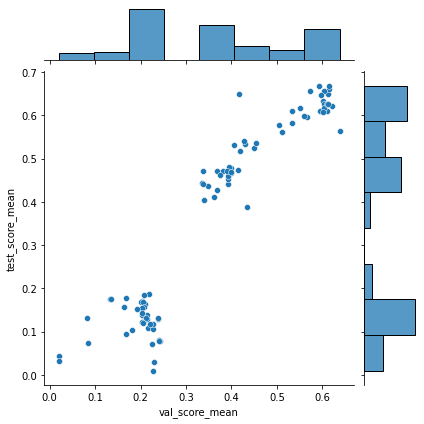

In [7]:
x = "val_score_mean"
y = "test_score_mean"

import seaborn as sns
#p = sns.regplot(x=x, y=y, data=all_df)

sns.jointplot(x=x, y=y, data=all_df)


In [8]:
all_df = all_df.drop(columns=["tree_method", "gpu"])
# fill freeze nan embed nans with 0
all_df.loc[all_df["freeze_nan_embed"] == "NaN", "freeze_nan_embed"] = 0
all_df = all_df[all_df["freeze_nan_embed"] != 1].drop(columns=["freeze_nan_embed"])
# fill norm nan embed nans with 0
all_df.loc[all_df["norm_nan_embed"] == "NaN", "norm_nan_embed"] = 0
all_df = all_df[all_df["norm_nan_embed"] != 0].drop(columns=["norm_nan_embed"])

In [9]:
final_df = all_df[all_df["max_epochs"] == 30]
final_df = final_df[final_df["opt_steps"] == 200]

In [10]:
final_df.to_csv("tunings/final_df.csv")

In [11]:
final_df.columns

Index(['model_type', 'db_name', 'fill_type', 'block_size', 'bs', 'max_len',
       'max_epochs', 'lr', 'weight_decay', 'grad_clip_val', 'hidden_size',
       'mode', 'gpt_name', 'pretrained', 'flat_block_size', 'l1_ratio',
       'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample',
       'colsample_bytree', 'opt_steps', 'nan_embed_size',
       'flat_block_size_range', 'reduction_factor', 'lr', 'weight_decay',
       'grad_clip_val', 'bs', 'val_score_mean', 'val_score_std',
       'test_score_mean', 'test_score_std', 'n_estimators', 'max_depth',
       'subsample', 'colsample_bytree', 'gamma', 'min_child_weight',
       'flat_block_size', 'C', 'max_iter', 'l1_ratio'],
      dtype='object')

In [12]:
score_comp = final_df[["model_type", "db_name", "val_score_mean", "test_score_mean",
                       "nan_embed_size",
                      "pretrained", "hidden_size", "fill_type", "flat_block_size", "val_score_std", 
                      "test_score_std", "gpt_name", "max_len", "block_size"]]

In [13]:
score_comp

,model_type,db_name,val_score_mean,test_score_mean,nan_embed_size,pretrained,hidden_size,fill_type,flat_block_size,flat_block_size,val_score_std,test_score_std,gpt_name,max_len,block_size
0,gpt,MIMIC,0.214198,0.137506,NaN,1,2048,none,8.0,NaN,0.022471,0.021376,gpt2,128,0
1,xgb,MIMIC,0.227294,0.009541,NaN,1,2048,median,5.0,5.0,0.012613,0.041947,gpt2,128,0
3,linear,MIMIC,0.167050,0.177070,NaN,1,2048,median,32.0,32.0,0.000000,0.000000,gpt2,128,0
4,rnn,MIMIC,0.219050,0.187539,NaN,True,2048,median,8.0,NaN,0.001164,0.001484,gpt2,128,0
6,rnn,MIMIC,0.162698,0.155981,NaN,True,512,median,8.0,NaN,0.027030,0.013137,gpt2,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,mlp,UKE,0.390905,0.470693,512.0,1,1024,median,8.0,NaN,0.006306,0.004221,gpt2,512,128
83,mlp,UKE,0.368658,0.427488,4.0,1,2048,none,8.0,NaN,0.011768,0.009339,gpt2,512,128
84,mlp,UKE,0.399797,0.468380,32.0,1,2048,none,8.0,NaN,0.010820,0.010301,gpt2,512,128
86,rnn,UKE,0.611323,0.625425,NaN,1,2048,none,8.0,NaN,0.016128,0.009132,gpt2,128,0


In [14]:
all_cfgs[0].keys()

dict_keys(['model_type', 'target_name', 'db_name', 'minutes', 'seed', 'features', 'fill_type', 'target_nan_quantile', 'block_size', 'random_starts', 'train_noise_std', 'bs', 'min_len', 'max_len', 'max_epochs', 'lr', 'use_nan_embed', 'weight_decay', 'grad_clip_val', 'val_check_interval', 'max_steps', 'use_macro_loss', 'use_pos_weight', 'use_huber', 'dropout', 'hidden_size', 'use_static', 'rnn_layers', 'rnn_type', 'mode', 'clip_name', 'gpt_name', 'pretrained', 'flat_block_size', 'alpha', 'l1_ratio', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'tree_method', 'gpu', 'opt_steps', 'tune_hebo'])

In [15]:
final_df.columns

Index(['model_type', 'db_name', 'fill_type', 'block_size', 'bs', 'max_len',
       'max_epochs', 'lr', 'weight_decay', 'grad_clip_val', 'hidden_size',
       'mode', 'gpt_name', 'pretrained', 'flat_block_size', 'l1_ratio',
       'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample',
       'colsample_bytree', 'opt_steps', 'nan_embed_size',
       'flat_block_size_range', 'reduction_factor', 'lr', 'weight_decay',
       'grad_clip_val', 'bs', 'val_score_mean', 'val_score_std',
       'test_score_mean', 'test_score_std', 'n_estimators', 'max_depth',
       'subsample', 'colsample_bytree', 'gamma', 'min_child_weight',
       'flat_block_size', 'C', 'max_iter', 'l1_ratio'],
      dtype='object')

In [16]:
score_comp[score_comp["model_type"] == "mlp"]

,model_type,db_name,val_score_mean,test_score_mean,nan_embed_size,pretrained,hidden_size,fill_type,flat_block_size,flat_block_size,val_score_std,test_score_std,gpt_name,max_len,block_size
9,mlp,MIMIC,0.238967,0.128347,512.0,1,2048,none,8.0,NaN,0.003585,0.004285,gpt2,128,0
12,mlp,MIMIC,0.240922,0.079849,512.0,1,2048,median,8.0,NaN,0.006787,0.008114,gpt2,128,0
21,mlp,MIMIC,0.211952,0.130730,4.0,1,2048,none,8.0,NaN,0.008746,0.012670,gpt2,512,128
31,mlp,MIMIC,0.227492,0.116551,32.0,1,2048,none,8.0,NaN,0.003864,0.004808,gpt2,512,128
32,mlp,MIMIC,0.221210,0.118193,8.0,1,2048,none,8.0,NaN,0.009572,0.010854,gpt2,512,128
33,mlp,MIMIC,0.239140,0.131054,128.0,1,2048,none,8.0,NaN,0.004663,0.002521,gpt2,512,128
49,mlp,UKE,0.347715,0.437302,512.0,1,32,median,8.0,NaN,0.014329,0.004259,gpt2,512,128
56,mlp,UKE,0.415277,0.474050,128.0,1,2048,none,8.0,NaN,0.008119,0.006826,gpt2,512,128
57,mlp,UKE,0.392350,0.440580,512.0,1,128,median,8.0,NaN,0.009612,0.006337,gpt2,512,128
59,mlp,UKE,0.532452,0.581865,512.0,1,2048,none,8.0,NaN,0.005378,0.000747,gpt2,128,0


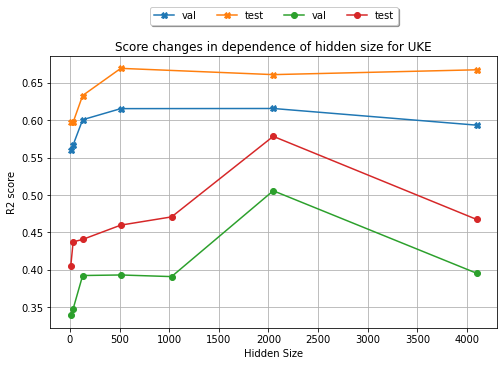

In [36]:
db = "UKE"
fill_type = "median"# "none", "median"

plot_df = score_comp[score_comp["db_name"] == db].sort_values("model_type").drop(columns=["db_name"])

first_models = plot_df[plot_df["fill_type"] == fill_type]

import matplotlib.pyplot as plt

ax = plt.figure(figsize=(8,5)).gca()
# rnn best hidden size
rnn_df = first_models[first_models["model_type"] == "rnn"].sort_values("hidden_size").copy()
ax1 = rnn_df.plot(x="hidden_size", y="val_score_mean", kind="line", label="val", style="-X", ax=ax)
ax = rnn_df.plot(x="hidden_size", y="test_score_mean", kind="line", label="test", style="-X", ax=ax)

mlp_df = first_models[first_models["model_type"] == "mlp"].sort_values("hidden_size").copy()
mlp_df.plot(x="hidden_size", y="val_score_mean", kind="line", label="val", style="-o", ax=ax)
mlp_df.plot(x="hidden_size", y="test_score_mean", kind="line", label="test", style="-o", ax=ax)

plt.grid(True)
plt.ylabel("R2 score")
plt.xlabel("Hidden Size")
plt.title(f"Score changes in dependence of hidden size for {db}")
# x-axis in log2 scale
#plt.xscale('log', base=2)
# put legend at top
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
            fancybox=True, shadow=True, ncol=5)
#rnn_df[["hidden_size", "val_score_mean", "val_score_std", "test_score_mean", "test_score_std"]]


In [37]:
def clean_df(df):
    # drop columsn that only have one unique value
    df = df.drop(columns=df.nunique()[df.nunique()<=1].index)
    # for each column name that appears twice, only keep one
    df = df.loc[:,~df.columns.duplicated()]
    return df


In [38]:
# investigate block size performance
rnn_models = all_df[all_df["model_type"] == "rnn"].sort_values("block_size")
rnn_models = rnn_models[rnn_models["db_name"] == "MIMIC"]
rnn_models = rnn_models[rnn_models["fill_type"] == "none"]

rnn_models = clean_df(rnn_models)
best = rnn_models.groupby("block_size").apply(lambda x: x.nlargest(1, "test_score_mean")).reset_index(drop=True)
print(best)
print()

mlp_models = all_df[all_df["model_type"] == "mlp"].sort_values("block_size")
mlp_models = mlp_models[mlp_models["db_name"] == "UKE"]
#rnn_models = rnn_models[rnn_models["fill_type"] == "none"]
# sort out rows where, if the fill type is none and the nan_embed_size different from 512
mlp_models = mlp_models[(mlp_models["fill_type"] == "median") | (mlp_models["nan_embed_size"] == 512)]
mlp_models = clean_df(mlp_models)
best = mlp_models.groupby("block_size").apply(lambda x: x.nlargest(1, "test_score_mean")).reset_index(drop=True)
print(best)
mlp_models



   block_size  bs  max_len        lr  weight_decay  grad_clip_val  \
0           0   6      128  0.001073           0.8            1.0   
1         128   2      512  0.000050           0.2            1.9   

   hidden_size  val_score_mean  val_score_std  test_score_mean  test_score_std  
0          128        0.206927       0.009757         0.157275        0.008397  
1         2048        0.205770       0.012331         0.168152        0.016073  

  fill_type  block_size  bs  max_len        lr  weight_decay  grad_clip_val  \
0      none           0   5      128  0.000203           1.8            0.0   
1    median         128   3      512  0.002892           0.5            0.0   

   hidden_size  val_score_mean  val_score_std  test_score_mean  test_score_std  
0         2048        0.532452       0.005378         0.581865        0.000747  
1         1024        0.390905       0.006306         0.470693        0.004221  


,fill_type,block_size,bs,max_len,lr,weight_decay,grad_clip_val,hidden_size,val_score_mean,val_score_std,test_score_mean,test_score_std
60,median,0,5,128,0.001319,2.9,0.0,2048,0.505598,0.004595,0.578306,0.003920
59,none,0,5,128,0.000203,1.8,0.0,2048,0.532452,0.005378,0.581865,0.000747
82,median,128,3,512,0.002892,0.5,0.0,1024,0.390905,0.006306,0.470693,0.004221
81,median,128,3,512,0.000738,0.0,0.0,512,0.393079,0.002620,0.459678,0.007552
73,median,128,2,512,0.009417,0.0,0.0,8,0.339004,0.006537,0.404439,0.002464
61,median,128,2,512,0.000173,2.7,0.0,4096,0.395440,0.000691,0.467331,0.002496
57,median,128,5,512,0.008735,0.0,0.0,128,0.392350,0.009612,0.440580,0.006337
49,median,128,4,512,0.007695,0.0,2.0,32,0.347715,0.014329,0.437302,0.004259


In [39]:
all_df.sort_values("block_size")

,model_type,db_name,fill_type,block_size,bs,max_len,max_epochs,lr,weight_decay,grad_clip_val,...,n_estimators,max_depth,subsample,colsample_bytree,gamma,min_child_weight,flat_block_size,C,max_iter,l1_ratio
0,gpt,MIMIC,none,0,6,128,30,0.001273,3.5,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,gpt,UKE,median,0,5,128,30,0.001231,0.1,1.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,rnn,UKE,median,0,2,128,30,0.011618,1.6,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,linear,UKE,median,0,8,128,30,0.000100,0.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,32.0,0.003232,322.0,0.0
88,rnn,UKE,none,0,4,128,20,0.022186,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,gpt,UKE,median,128,6,512,30,0.001046,0.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,mlp,UKE,median,128,5,512,30,0.008735,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,mlp,UKE,none,128,5,512,30,0.000286,1.3,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,mlp,MIMIC,none,128,4,512,30,0.000595,3.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
plot_df.sort_values("block_size")

,model_type,val_score_mean,test_score_mean,nan_embed_size,pretrained,hidden_size,fill_type,flat_block_size,flat_block_size,val_score_std,test_score_std,gpt_name,max_len,block_size
47,xgb,0.382447,0.471544,NaN,1,2048,median,30.0,30.0,0.018524,1.001907e-02,gpt2,128,0
79,rnn,0.559810,0.597520,NaN,1,8,median,8.0,NaN,0.027043,1.521155e-02,gpt2,128,0
66,xgb,0.369266,0.472268,NaN,NaN,2048,median,17.0,17.0,0.015382,1.696511e-02,gpt2,128,0
76,rnn,0.593258,0.667211,NaN,1,4096,median,8.0,NaN,0.037999,1.163006e-02,gpt2,128,0
38,rnn,0.566826,0.597159,NaN,1,32,median,8.0,NaN,0.077463,2.590599e-02,gpt2,128,0
60,mlp,0.505598,0.578306,512.0,1,2048,median,8.0,NaN,0.004595,3.919906e-03,gpt2,128,0
59,mlp,0.532452,0.581865,512.0,1,2048,none,8.0,NaN,0.005378,7.473097e-04,gpt2,128,0
71,rnn,0.604150,0.617772,NaN,1,2048,none,8.0,NaN,0.031242,1.840504e-02,gpt2,128,0
70,rnn,0.615332,0.669147,NaN,True,512,median,8.0,NaN,0.021811,1.170195e-02,gpt2,128,0
86,rnn,0.611323,0.625425,NaN,1,2048,none,8.0,NaN,0.016128,9.132055e-03,gpt2,128,0


,block_size,bs,max_len,lr,weight_decay,grad_clip_val,gpt_name,reduction_factor,val_score_mean,val_score_std,test_score_mean,test_score_std
58,128,6,512,0.001046,0.1,0.0,gpt2,16.0,0.449558,0.026680,0.524154,0.009469
72,128,5,512,0.000909,1.0,0.9,distilgpt2,16.0,0.454880,0.051079,0.536604,0.010847


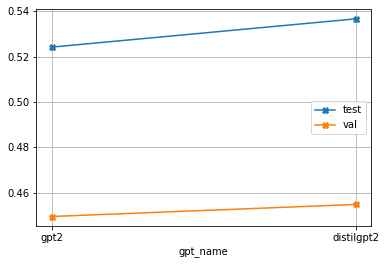

In [41]:
# plot gpt sizes
gpt_models = all_df[all_df["model_type"] == "gpt"]
gpt_models = gpt_models[gpt_models["pretrained"] == 1]
gpt_models = gpt_models[gpt_models["db_name"] == "UKE"]
gpt_models = gpt_models[gpt_models["fill_type"] == "median"]
# drop columsn that only have one unique value
gpt_models = gpt_models.drop(columns=gpt_models.nunique()[gpt_models.nunique()<=1].index)
# for each column name that appears twice, only keep one
gpt_models = gpt_models.loc[:,~gpt_models.columns.duplicated()]



gpt_sizes = gpt_models[gpt_models["reduction_factor"] == 16]
gpt_sizes = gpt_sizes[gpt_sizes["max_len"] == 512].sort_values("reduction_factor")

ax = gpt_sizes.plot(x="gpt_name", y="test_score_mean", kind="line", label="test", style="-X")
ax = gpt_sizes.plot(x="gpt_name", y="val_score_mean", kind="line", label="val", style="-X", ax=ax)

# set correct x-ticks with gpt names
plt.xticks(range(len(gpt_sizes)), gpt_sizes["gpt_name"])
plt.grid(True)
#plt.yticks(np.arange(0.52, 0.55, 0.01))

gpt_sizes


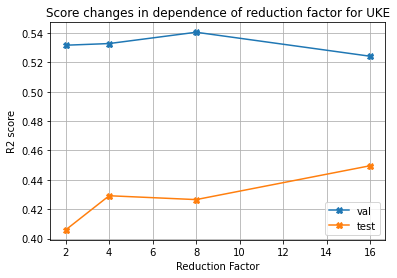

In [42]:
gpt_reduction_facs = gpt_models[gpt_models["gpt_name"] == "gpt2"]
gpt_reduction_facs = gpt_reduction_facs[gpt_reduction_facs["max_len"] == 512].sort_values("reduction_factor")

ax = gpt_reduction_facs.plot(x="reduction_factor", y="test_score_mean", kind="line", label="val", style="-X")
gpt_reduction_facs.plot(x="reduction_factor", y="val_score_mean", kind="line", label="test", style="-X", ax=ax)

# enabled grid 
plt.grid(True)
# make nicer
plt.ylabel("R2 score")
plt.xlabel("Reduction Factor")
plt.title(f"Score changes in dependence of reduction factor for {db}")
# only show relevant y ticks
import numpy as np
#plt.yticks(np.arange(0.4, 0.55, 0.01))

# gpt_reduction_facs


In [44]:
gpt_reduction_facs

,block_size,bs,max_len,lr,weight_decay,grad_clip_val,gpt_name,reduction_factor,val_score_mean,val_score_std,test_score_mean,test_score_std
46,128,6,512,0.000832,0.7,1.0,gpt2,2.0,0.405859,0.074603,0.531648,0.027515
35,128,5,512,0.000329,2.1,1.2,gpt2,4.0,0.429139,0.042392,0.532782,0.031609
69,128,5,512,0.000505,0.1,0.5,gpt2,8.0,0.426507,0.026479,0.540485,0.025449
58,128,6,512,0.001046,0.1,0.0,gpt2,16.0,0.449558,0.026680,0.524154,0.009469


,model_type,val_score_mean,test_score_mean,nan_embed_size,pretrained,hidden_size,fill_type,flat_block_size,flat_block_size,val_score_std,test_score_std,gpt_name,max_len,block_size
35,GPT,0.429139,0.532782,512.0,1,2048,median,8.0,NaN,0.042392,0.031609,gpt2,512,128
72,GPT,0.454880,0.536604,512.0,1,2048,median,8.0,NaN,0.051079,0.010847,distilgpt2,512,128
69,GPT,0.426507,0.540485,512.0,1,2048,median,8.0,NaN,0.026479,0.025449,gpt2,512,128
58,GPT,0.449558,0.524154,512.0,1,2048,median,8.0,NaN,0.026680,0.009469,gpt2,512,128
46,GPT,0.405859,0.531648,512.0,1,2048,median,8.0,NaN,0.074603,0.027515,gpt2,512,128
73,MLP,0.339004,0.404439,512.0,1,8,median,8.0,NaN,0.006537,0.002464,gpt2,512,128
57,MLP,0.392350,0.440580,512.0,1,128,median,8.0,NaN,0.009612,0.006337,gpt2,512,128
49,MLP,0.347715,0.437302,512.0,1,32,median,8.0,NaN,0.014329,0.004259,gpt2,512,128
82,MLP,0.390905,0.470693,512.0,1,1024,median,8.0,NaN,0.006306,0.004221,gpt2,512,128
81,MLP,0.393079,0.459678,512.0,1,512,median,8.0,NaN,0.002620,0.007552,gpt2,512,128


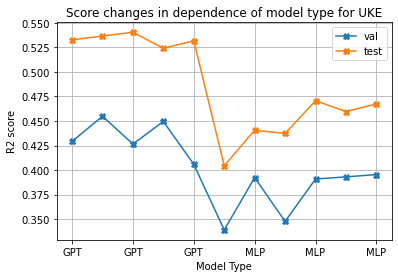

In [46]:
# plot for best model per model type
best_models = first_models.copy().sort_values("model_type")
#best_models = best_models[best_models[(best_models["hidden_size"] == 2048) & (best_models["hidden_size"] == 2048)]]
#best_models = best_models[best_models["gpt_name"] == "gpt2"]

best_models = best_models[best_models["block_size"] == 128]

#best_models = best_models[(best_models["pretrained"] == 0) | (best_models["model_type"] != "gpt")]
#best_models = best_models.groupby("model_type").mean().reset_index().sort_values("test_score_mean", ascending=False)
# capitalize model_type
best_models["model_type"] = best_models["model_type"].str.upper()
ax1 = best_models.plot(x="model_type", y="val_score_mean", kind="line", label="val", style="-X")
ax2 = best_models.plot(x="model_type", y="test_score_mean", kind="line", label="test", ax=ax1, style="-X")
plt.ylabel("R2 score")
plt.xlabel("Model Type")
plt.title(f"Score changes in dependence of model type for {db}")
# enabled grid
plt.grid(True)


#sns.barplot(x="model_type", y="val_score_mean", data=best_models)
# plot with std as error bar
#sns.barplot(x="model_type", y="val_score_mean", data=best_models, yerr="val_score_std")
best_models


In [93]:
fill_type_df = plot_df[plot_df["hidden_size"] == 2048].sort_values("model_type")

fill_type_df
#best_models = plot_df.groupby("model_type").mean().reset_index().sort_values("test_score_mean", ascending=False)



,model_type,val_score_mean,test_score_mean,nan_embed_size,pretrained,hidden_size,fill_type,flat_block_size,flat_block_size,val_score_std,test_score_std,gpt_name
35,gpt,0.429139,0.532782,512.0,1,2048,median,8.0,NaN,0.042392,3.160912e-02,gpt2
75,gpt,0.610998,0.626319,NaN,0,2048,median,8.0,NaN,0.049107,1.309917e-02,gpt2
72,gpt,0.454880,0.536604,512.0,1,2048,median,8.0,NaN,0.051079,1.084707e-02,distilgpt2
69,gpt,0.426507,0.540485,512.0,1,2048,median,8.0,NaN,0.026479,2.544859e-02,gpt2
65,gpt,0.572395,0.657517,NaN,1,2048,none,8.0,NaN,0.037922,1.324722e-02,gpt2
58,gpt,0.449558,0.524154,512.0,1,2048,median,8.0,NaN,0.026680,9.468910e-03,gpt2
46,gpt,0.405859,0.531648,512.0,1,2048,median,8.0,NaN,0.074603,2.751452e-02,gpt2
89,gpt,0.601076,0.607094,NaN,1,2048,median,8.0,NaN,0.070674,1.971827e-02,gpt2
40,gpt,0.637868,0.563642,512.0,1,2048,none,8.0,NaN,0.029661,3.385785e-02,gpt2
42,gpt,0.609735,0.610409,NaN,0,2048,median,8.0,NaN,0.050700,1.615280e-02,gpt2


In [94]:
rows = []
for model_type in fill_type_df["model_type"].unique():
    model_type_df = fill_type_df[fill_type_df["model_type"] == model_type]
    for fill_type in model_type_df["fill_type"].unique():
        sub_df = model_type_df[model_type_df["fill_type"] == fill_type]
        best = sub_df.nlargest(1, "val_score_mean")
        rows.append(best)

pd.concat(rows).sort_values("test_score_mean", ascending=False)
       
#fill_type_df.groupby("model_type").apply(lambda model_df: model_df.groupby("fill_type").apply(lambda x: x.nlargest(1, "val_score_mean")))

,model_type,val_score_mean,test_score_mean,nan_embed_size,pretrained,hidden_size,fill_type,flat_block_size,flat_block_size,val_score_std,test_score_std,gpt_name
37,rnn,0.615531,0.660775,NaN,True,2048,median,8.0,NaN,0.018903,8.855067e-03,gpt2
75,gpt,0.610998,0.626319,NaN,0,2048,median,8.0,NaN,0.049107,1.309917e-02,gpt2
53,rnn,0.620786,0.620956,512.0,1,2048,none,8.0,NaN,0.025969,2.467148e-02,gpt2
59,mlp,0.532452,0.581865,512.0,1,2048,none,8.0,NaN,0.005378,7.473097e-04,gpt2
60,mlp,0.505598,0.578306,512.0,1,2048,median,8.0,NaN,0.004595,3.919906e-03,gpt2
40,gpt,0.637868,0.563642,512.0,1,2048,none,8.0,NaN,0.029661,3.385785e-02,gpt2
47,xgb,0.382447,0.471544,NaN,1,2048,median,30.0,30.0,0.018524,1.001907e-02,gpt2
77,xgb,0.375124,0.462741,NaN,1,2048,none,32.0,32.0,0.020459,1.249036e-02,gpt2
68,rf,0.360712,0.411492,NaN,1,2048,median,31.0,31.0,0.000000,5.551115e-17,gpt2
45,linear,0.132717,0.174417,NaN,1,2048,median,32.0,32.0,0.000000,0.000000e+00,gpt2


In [95]:
fill_type_df.groupby("model_type").mean().reset_index().sort_values("test_score_mean", ascending=False)

,model_type,val_score_mean,test_score_mean,nan_embed_size,hidden_size,flat_block_size,flat_block_size,val_score_std,test_score_std
4,rnn,0.612947,0.631232,512.000000,2048.0,8.000000,NaN,0.023060,1.526591e-02
0,gpt,0.519801,0.573065,512.000000,2048.0,8.000000,NaN,0.045930,2.009635e-02
2,mlp,0.435618,0.496990,199.333333,2048.0,8.000000,NaN,0.008036,6.454123e-03
5,xgb,0.375612,0.468851,NaN,2048.0,26.333333,26.333333,0.018122,1.315818e-02
3,rf,0.360712,0.411492,NaN,2048.0,31.000000,31.000000,0.000000,5.551115e-17
1,linear,0.132717,0.174417,NaN,2048.0,32.000000,32.000000,0.000000,0.000000e+00
